In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions,title="Confusion Matrix"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels




In [3]:
import pickle
def read_h5():
    lst = []
    with open("X and Y Dataset/x_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/x_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    return lst
def read_properties():
    lst = None
    with open('X and Y Dataset/properties.pickle','rb+') as fd:
        lst = pickle.load(fd)
    return lst
x_train,y_train,x_test,y_test = read_h5()
TIME_PERIODS = 80
num_time_periods, num_sensors,num_classes,input_shape = read_properties()
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]


--- Create neural network model ---

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 10)            160       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 10)            510       
_________________________________________________________________
global_average_pooling1d_1 ( (None, 10)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense) 

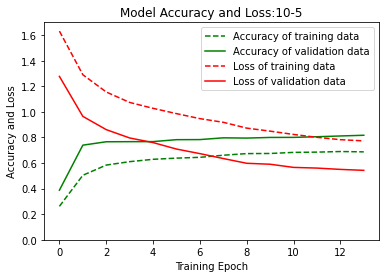


--- Check against test data ---

6584/6584 [==============================] - 0s 28us/step

Accuracy on test data: 0.74

Loss on test data: 0.62

--- Confusion matrix for test data ---



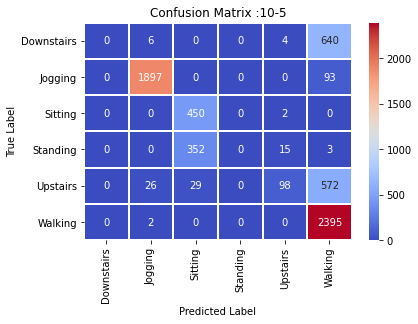


--- Classification report for test data 10:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.95      0.97      1990
           2       0.54      1.00      0.70       452
           3       0.00      0.00      0.00       370
           4       0.82      0.14      0.23       725
           5       0.65      1.00      0.79      2397

    accuracy                           0.74      6584
   macro avg       0.50      0.51      0.45      6584
weighted avg       0.66      0.74      0.65      6584



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7351154088973999

In [5]:
print("\n--- Create neural network model ---\n")
def call_model(filters_val=10,kernal_val=5):
    # 1D CNN neural network
    model_m = Sequential()
    model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    model_m.add(Conv1D(filters=filters_val, kernel_size=kernal_val, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
    model_m.add(MaxPooling1D(3))
    model_m.add(Conv1D(filters=filters_val, kernel_size=kernal_val, activation='relu'))
    model_m.add(GlobalAveragePooling1D())
    model_m.add(Dropout(0.5))
    model_m.add(Dense(num_classes, activation='softmax'))
    print(model_m.summary())
    # Accuracy on training data: 99%
    # Accuracy on test data: 91%

    print("\n--- Fit the model ---\n")

    # The EarlyStopping callback monitors training accuracy:
    # if it fails to improve for two consecutive epochs,
    # training stops early
    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
    ]

    model_m.compile(loss='categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])

    BATCH_SIZE = 200
    EPOCHS = 25

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model_m.fit(x_train,
                          y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_split=0.2,
                          verbose=1)

    print("\n--- Learning curve of model training ---\n")

    # summarize history for accuracy and loss
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history.history['loss'], "r--", label="Loss of training data")
    plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss:'+str(filters_val)+"-"+str(kernal_val))
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    print("\n--- Check against test data ---\n")

    score = model_m.evaluate(x_test, y_test, verbose=1)

    print("\nAccuracy on test data: %0.2f" % score[1])
    print("\nLoss on test data: %0.2f" % score[0])

    print("\n--- Confusion matrix for test data ---\n")

    y_pred_test = model_m.predict(x_test)
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test,title="Confusion Matrix :"+str(filters_val)+"-"+str(kernal_val))
    print("\n--- Classification report for test data "+str(filters_val)+":"+str(kernal_val)+"---\n")

    print(classification_report(max_y_test, max_y_pred_test))
    return score[1]
call_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 79, 5)             35        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 26, 5)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 25, 5)             55        
_________________________________________________________________
global_average_pooling1d_2 ( (None, 5)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

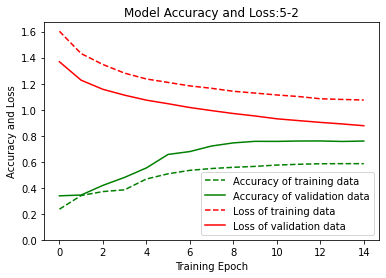


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.55

Loss on test data: 1.04

--- Confusion matrix for test data ---



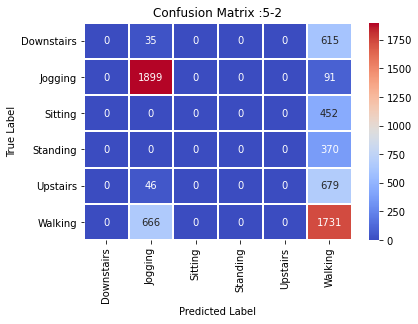


--- Classification report for test data 5:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.72      0.95      0.82      1990
           2       0.00      0.00      0.00       452
           3       0.00      0.00      0.00       370
           4       0.00      0.00      0.00       725
           5       0.44      0.72      0.55      2397

    accuracy                           0.55      6584
   macro avg       0.19      0.28      0.23      6584
weighted avg       0.38      0.55      0.45      6584

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 79, 10)            70        
________________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 52us/step - loss: 1.5797 - accuracy: 0.3474 - val_loss: 1.2741 - val_accuracy: 0.5882
Epoch 2/25
16694/16694 [==============================] - 1s 37us/step - loss: 1.3606 - accuracy: 0.4358 - val_loss: 1.1306 - val_accuracy: 0.6047
Epoch 3/25
16694/16694 [==============================] - 0s 30us/step - loss: 1.2708 - accuracy: 0.4887 - val_loss: 1.0521 - val_accuracy: 0.6885
Epoch 4/25
16694/16694 [==============================] - 0s 28us/step - loss: 1.2100 - accuracy: 0.5303 - val_loss: 0.9867 - val_accuracy: 0.7127
Epoch 5/25
16694/16694 [==============================] - 1s 31us/step - loss: 1.1559 - accuracy: 0.5619 - val_loss: 0.9285 - val_accuracy: 0.7465
Epoch 6/25
16694/16694 [==============================] - 1s 32us/step - loss: 1.1143 - accuracy: 0.5825 - val_loss: 0.8841 - val_accuracy: 0.7542
Epoch 7/25
16694/16694 [==============================] - 0s 27us/ste

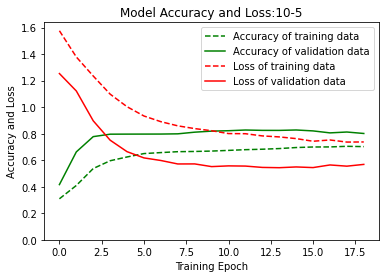


--- Check against test data ---

6584/6584 [==============================] - 0s 32us/step

Accuracy on test data: 0.76

Loss on test data: 0.60

--- Confusion matrix for test data ---



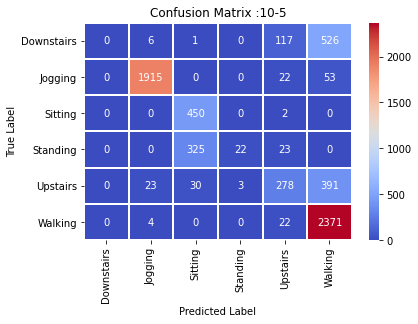


--- Classification report for test data 10:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.96      0.97      1990
           2       0.56      1.00      0.72       452
           3       0.88      0.06      0.11       370
           4       0.60      0.38      0.47       725
           5       0.71      0.99      0.83      2397

    accuracy                           0.76      6584
   macro avg       0.62      0.56      0.52      6584
weighted avg       0.71      0.76      0.70      6584

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 73, 10)            250       
_______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 43us/step - loss: 1.4323 - accuracy: 0.4611 - val_loss: 0.9834 - val_accuracy: 0.7266
Epoch 2/25
16694/16694 [==============================] - 0s 29us/step - loss: 1.1266 - accuracy: 0.5952 - val_loss: 0.7711 - val_accuracy: 0.7623
Epoch 3/25
16694/16694 [==============================] - 0s 30us/step - loss: 1.0075 - accuracy: 0.6304 - val_loss: 0.6740 - val_accuracy: 0.7604
Epoch 4/25
16694/16694 [==============================] - 0s 28us/step - loss: 0.9361 - accuracy: 0.6413 - val_loss: 0.6325 - val_accuracy: 0.7626
Epoch 5/25
16694/16694 [==============================] - 1s 32us/step - loss: 0.8976 - accuracy: 0.6448 - val_loss: 0.6070 - val_accuracy: 0.7678
Epoch 6/25
16694/16694 [==============================] - 0s 29us/step - loss: 0.8624 - accuracy: 0.6523 - val_loss: 0.5957 - val_accuracy: 0.7755
Epoch 7/25
16694/16694 [==============================] - 0s 27us/ste

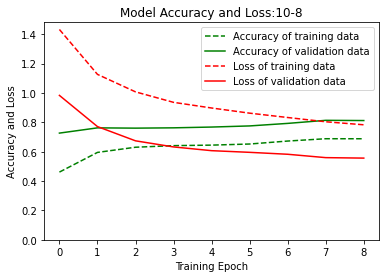


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.76

Loss on test data: 0.66

--- Confusion matrix for test data ---



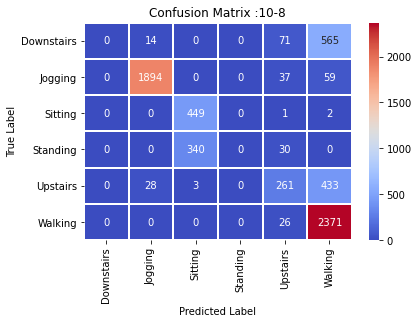


--- Classification report for test data 10:8---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.98      0.95      0.96      1990
           2       0.57      0.99      0.72       452
           3       0.00      0.00      0.00       370
           4       0.61      0.36      0.45       725
           5       0.69      0.99      0.81      2397

    accuracy                           0.76      6584
   macro avg       0.47      0.55      0.49      6584
weighted avg       0.65      0.76      0.69      6584

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 79, 15)            105       
_______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 44us/step - loss: 1.6837 - accuracy: 0.2898 - val_loss: 1.3501 - val_accuracy: 0.4971
Epoch 2/25
16694/16694 [==============================] - 0s 29us/step - loss: 1.4134 - accuracy: 0.4374 - val_loss: 1.1899 - val_accuracy: 0.5678
Epoch 3/25
16694/16694 [==============================] - 0s 29us/step - loss: 1.2875 - accuracy: 0.5007 - val_loss: 1.0586 - val_accuracy: 0.6236
Epoch 4/25
16694/16694 [==============================] - 1s 33us/step - loss: 1.1887 - accuracy: 0.5525 - val_loss: 0.9682 - val_accuracy: 0.6756
Epoch 5/25
16694/16694 [==============================] - 0s 29us/step - loss: 1.1183 - accuracy: 0.5855 - val_loss: 0.8971 - val_accuracy: 0.7298
Epoch 6/25
16694/16694 [==============================] - 1s 30us/step - loss: 1.0464 - accuracy: 0.6159 - val_loss: 0.8114 - val_accuracy: 0.7621
Epoch 7/25
16694/16694 [==============================] - 0s 30us/ste

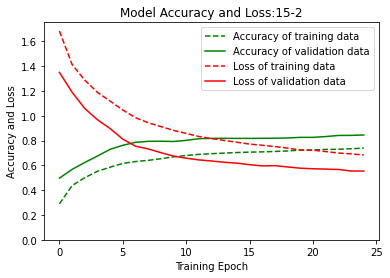


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.73

Loss on test data: 0.66

--- Confusion matrix for test data ---



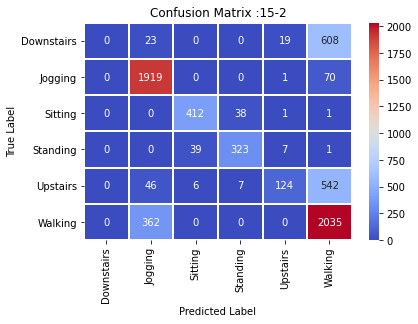


--- Classification report for test data 15:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.82      0.96      0.88      1990
           2       0.90      0.91      0.91       452
           3       0.88      0.87      0.88       370
           4       0.82      0.17      0.28       725
           5       0.62      0.85      0.72      2397

    accuracy                           0.73      6584
   macro avg       0.67      0.63      0.61      6584
weighted avg       0.68      0.73      0.67      6584



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 76, 15)            240       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 25, 15)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 21, 15)            1140      
_________________________________________________________________
global_average_pooling1d_7 ( (None, 15)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

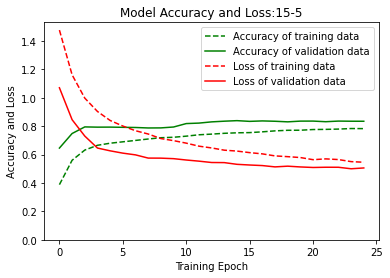


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.81

Loss on test data: 0.49

--- Confusion matrix for test data ---



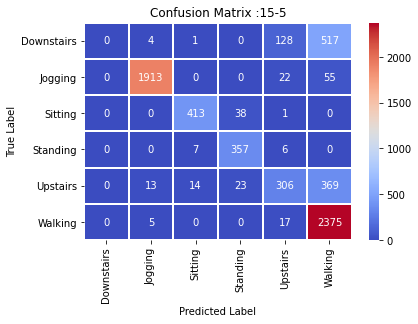


--- Classification report for test data 15:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.99      0.96      0.97      1990
           2       0.95      0.91      0.93       452
           3       0.85      0.96      0.91       370
           4       0.64      0.42      0.51       725
           5       0.72      0.99      0.83      2397

    accuracy                           0.81      6584
   macro avg       0.69      0.71      0.69      6584
weighted avg       0.74      0.81      0.77      6584

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 73, 15)            375       
_______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 41us/step - loss: 1.3797 - accuracy: 0.4641 - val_loss: 0.8587 - val_accuracy: 0.7345
Epoch 2/25
16694/16694 [==============================] - 1s 36us/step - loss: 0.9925 - accuracy: 0.6304 - val_loss: 0.6680 - val_accuracy: 0.7508
Epoch 3/25
16694/16694 [==============================] - 1s 36us/step - loss: 0.8806 - accuracy: 0.6565 - val_loss: 0.6287 - val_accuracy: 0.7789
Epoch 4/25
16694/16694 [==============================] - 1s 51us/step - loss: 0.7880 - accuracy: 0.6911 - val_loss: 0.5905 - val_accuracy: 0.7861
Epoch 5/25
16694/16694 [==============================] - 1s 42us/step - loss: 0.7286 - accuracy: 0.7138 - val_loss: 0.5888 - val_accuracy: 0.8129
Epoch 6/25
16694/16694 [==============================] - 1s 34us/step - loss: 0.6928 - accuracy: 0.7273 - val_loss: 0.5697 - val_accuracy: 0.8258
Epoch 7/25
16694/16694 [==============================] - 1s 42us/ste

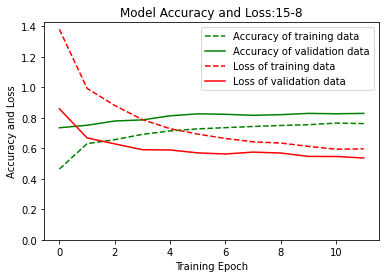


--- Check against test data ---

6584/6584 [==============================] - 0s 23us/step

Accuracy on test data: 0.82

Loss on test data: 0.51

--- Confusion matrix for test data ---



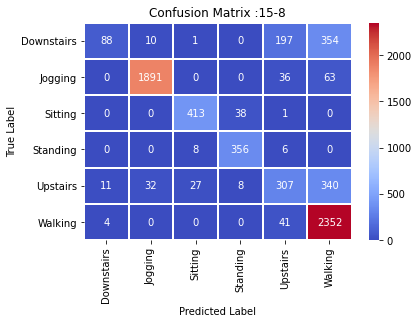


--- Classification report for test data 15:8---

              precision    recall  f1-score   support

           0       0.85      0.14      0.23       650
           1       0.98      0.95      0.96      1990
           2       0.92      0.91      0.92       452
           3       0.89      0.96      0.92       370
           4       0.52      0.42      0.47       725
           5       0.76      0.98      0.85      2397

    accuracy                           0.82      6584
   macro avg       0.82      0.73      0.73      6584
weighted avg       0.83      0.82      0.79      6584

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 71, 15)            465       
______________________________________________________

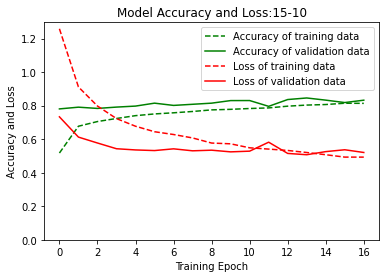


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.84

Loss on test data: 0.47

--- Confusion matrix for test data ---



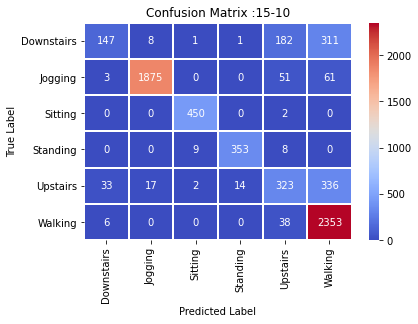


--- Classification report for test data 15:10---

              precision    recall  f1-score   support

           0       0.78      0.23      0.35       650
           1       0.99      0.94      0.96      1990
           2       0.97      1.00      0.98       452
           3       0.96      0.95      0.96       370
           4       0.53      0.45      0.49       725
           5       0.77      0.98      0.86      2397

    accuracy                           0.84      6584
   macro avg       0.83      0.76      0.77      6584
weighted avg       0.83      0.84      0.81      6584

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 69, 15)            555       
_____________________________________________________

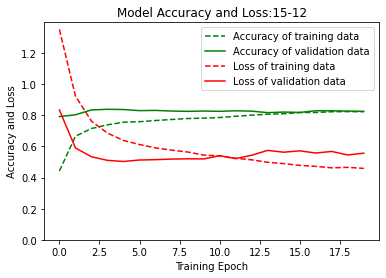


--- Check against test data ---

6584/6584 [==============================] - 0s 25us/step

Accuracy on test data: 0.84

Loss on test data: 0.45

--- Confusion matrix for test data ---



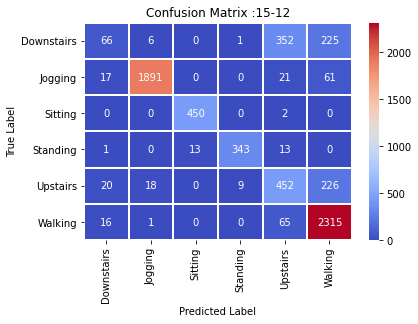


--- Classification report for test data 15:12---

              precision    recall  f1-score   support

           0       0.55      0.10      0.17       650
           1       0.99      0.95      0.97      1990
           2       0.97      1.00      0.98       452
           3       0.97      0.93      0.95       370
           4       0.50      0.62      0.55       725
           5       0.82      0.97      0.89      2397

    accuracy                           0.84      6584
   macro avg       0.80      0.76      0.75      6584
weighted avg       0.83      0.84      0.81      6584

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 79, 20)            140       
_____________________________________________________

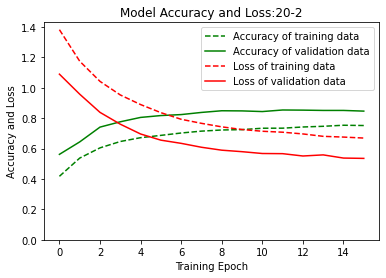


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.77

Loss on test data: 0.60

--- Confusion matrix for test data ---



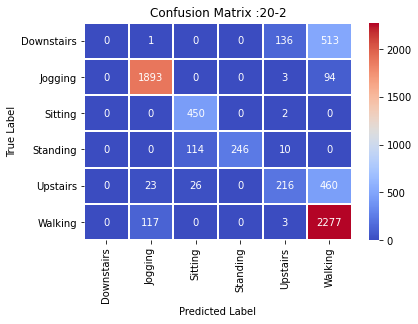


--- Classification report for test data 20:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.93      0.95      0.94      1990
           2       0.76      1.00      0.86       452
           3       1.00      0.66      0.80       370
           4       0.58      0.30      0.39       725
           5       0.68      0.95      0.79      2397

    accuracy                           0.77      6584
   macro avg       0.66      0.64      0.63      6584
weighted avg       0.70      0.77      0.72      6584

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 76, 20)            320       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 43us/step - loss: 1.3500 - accuracy: 0.4354 - val_loss: 0.9602 - val_accuracy: 0.6665
Epoch 2/25
16694/16694 [==============================] - 1s 30us/step - loss: 1.0224 - accuracy: 0.6242 - val_loss: 0.7124 - val_accuracy: 0.7961
Epoch 3/25
16694/16694 [==============================] - 1s 30us/step - loss: 0.8431 - accuracy: 0.6969 - val_loss: 0.6127 - val_accuracy: 0.7954
Epoch 4/25
16694/16694 [==============================] - 0s 30us/step - loss: 0.7720 - accuracy: 0.7137 - val_loss: 0.5776 - val_accuracy: 0.8016
Epoch 5/25
16694/16694 [==============================] - 1s 30us/step - loss: 0.7235 - accuracy: 0.7222 - val_loss: 0.5498 - val_accuracy: 0.8292
Epoch 6/25
16694/16694 [==============================] - 0s 30us/step - loss: 0.6837 - accuracy: 0.7317 - val_loss: 0.5263 - val_accuracy: 0.8215
Epoch 7/25
16694/16694 [==============================] - 1s 32us/ste

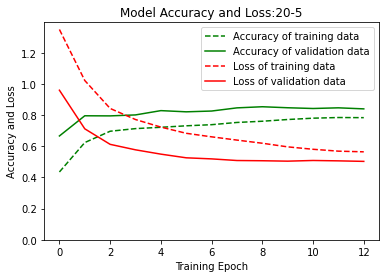


--- Check against test data ---

6584/6584 [==============================] - 0s 26us/step

Accuracy on test data: 0.81

Loss on test data: 0.52

--- Confusion matrix for test data ---



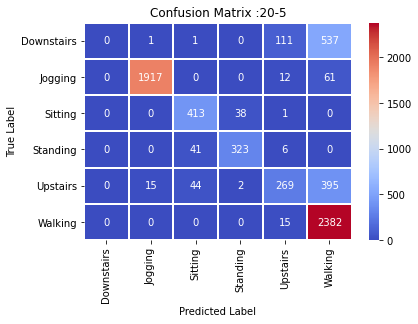


--- Classification report for test data 20:5---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.99      0.96      0.98      1990
           2       0.83      0.91      0.87       452
           3       0.89      0.87      0.88       370
           4       0.65      0.37      0.47       725
           5       0.71      0.99      0.83      2397

    accuracy                           0.81      6584
   macro avg       0.68      0.69      0.67      6584
weighted avg       0.74      0.81      0.76      6584

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 73, 20)            500       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 42us/step - loss: 1.2933 - accuracy: 0.4741 - val_loss: 0.8089 - val_accuracy: 0.7559
Epoch 2/25
16694/16694 [==============================] - 0s 30us/step - loss: 0.9296 - accuracy: 0.6472 - val_loss: 0.6404 - val_accuracy: 0.7904
Epoch 3/25
16694/16694 [==============================] - 1s 31us/step - loss: 0.7916 - accuracy: 0.7028 - val_loss: 0.5589 - val_accuracy: 0.7992
Epoch 4/25
16694/16694 [==============================] - 1s 30us/step - loss: 0.7055 - accuracy: 0.7320 - val_loss: 0.5425 - val_accuracy: 0.8083
Epoch 5/25
16694/16694 [==============================] - 1s 30us/step - loss: 0.6522 - accuracy: 0.7498 - val_loss: 0.5291 - val_accuracy: 0.8105
Epoch 6/25
16694/16694 [==============================] - 0s 30us/step - loss: 0.6142 - accuracy: 0.7579 - val_loss: 0.5109 - val_accuracy: 0.8289
Epoch 7/25
16694/16694 [==============================] - 1s 31us/ste

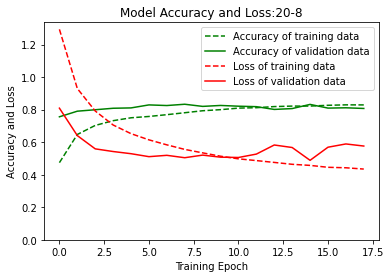


--- Check against test data ---

6584/6584 [==============================] - 0s 25us/step

Accuracy on test data: 0.85

Loss on test data: 0.46

--- Confusion matrix for test data ---



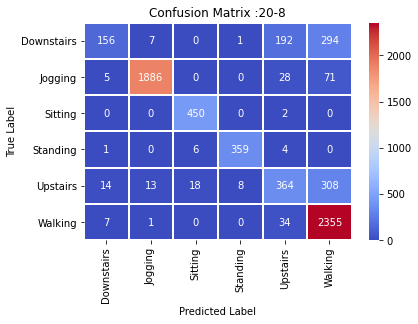


--- Classification report for test data 20:8---

              precision    recall  f1-score   support

           0       0.85      0.24      0.37       650
           1       0.99      0.95      0.97      1990
           2       0.95      1.00      0.97       452
           3       0.98      0.97      0.97       370
           4       0.58      0.50      0.54       725
           5       0.78      0.98      0.87      2397

    accuracy                           0.85      6584
   macro avg       0.85      0.77      0.78      6584
weighted avg       0.85      0.85      0.83      6584

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 71, 20)            620       
______________________________________________________

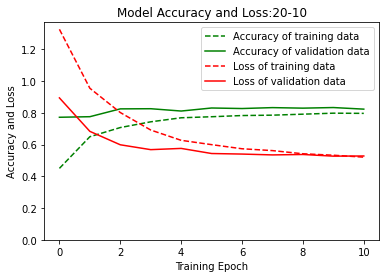


--- Check against test data ---

6584/6584 [==============================] - 0s 27us/step

Accuracy on test data: 0.82

Loss on test data: 0.48

--- Confusion matrix for test data ---



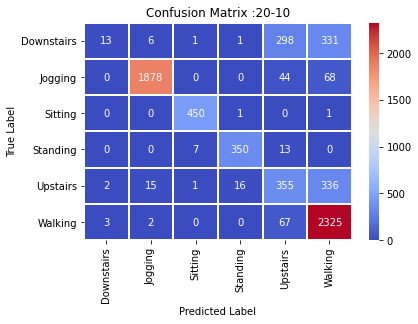


--- Classification report for test data 20:10---

              precision    recall  f1-score   support

           0       0.72      0.02      0.04       650
           1       0.99      0.94      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.95      0.95      0.95       370
           4       0.46      0.49      0.47       725
           5       0.76      0.97      0.85      2397

    accuracy                           0.82      6584
   macro avg       0.81      0.73      0.71      6584
weighted avg       0.82      0.82      0.78      6584

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 69, 20)            740       
_____________________________________________________

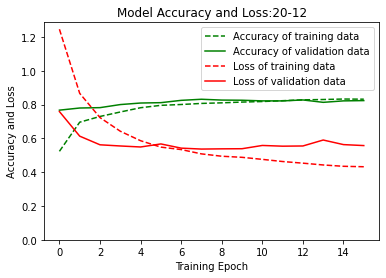


--- Check against test data ---

6584/6584 [==============================] - 0s 28us/step

Accuracy on test data: 0.84

Loss on test data: 0.44

--- Confusion matrix for test data ---



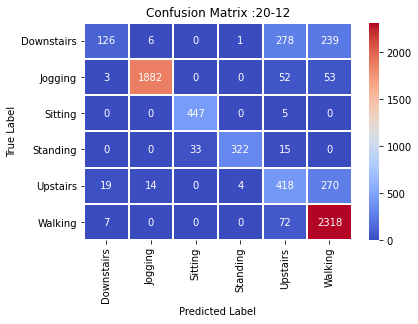


--- Classification report for test data 20:12---

              precision    recall  f1-score   support

           0       0.81      0.19      0.31       650
           1       0.99      0.95      0.97      1990
           2       0.93      0.99      0.96       452
           3       0.98      0.87      0.92       370
           4       0.50      0.58      0.53       725
           5       0.80      0.97      0.88      2397

    accuracy                           0.84      6584
   macro avg       0.84      0.76      0.76      6584
weighted avg       0.85      0.84      0.82      6584

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 66, 20)            920       
_____________________________________________________

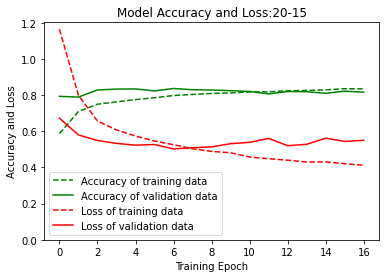


--- Check against test data ---

6584/6584 [==============================] - 0s 37us/step

Accuracy on test data: 0.84

Loss on test data: 0.48

--- Confusion matrix for test data ---



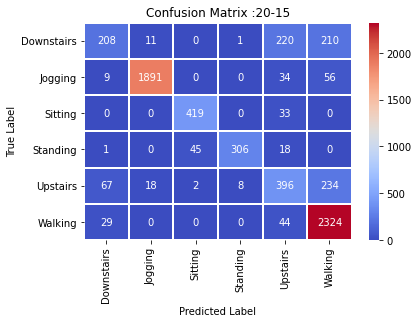


--- Classification report for test data 20:15---

              precision    recall  f1-score   support

           0       0.66      0.32      0.43       650
           1       0.98      0.95      0.97      1990
           2       0.90      0.93      0.91       452
           3       0.97      0.83      0.89       370
           4       0.53      0.55      0.54       725
           5       0.82      0.97      0.89      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.76      0.77      6584
weighted avg       0.84      0.84      0.83      6584

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 63, 20)            1100      
_____________________________________________________

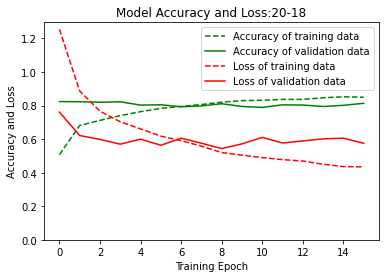


--- Check against test data ---

6584/6584 [==============================] - 0s 38us/step

Accuracy on test data: 0.84

Loss on test data: 0.45

--- Confusion matrix for test data ---



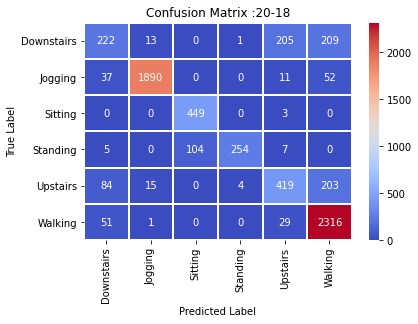


--- Classification report for test data 20:18---

              precision    recall  f1-score   support

           0       0.56      0.34      0.42       650
           1       0.98      0.95      0.97      1990
           2       0.81      0.99      0.89       452
           3       0.98      0.69      0.81       370
           4       0.62      0.58      0.60       725
           5       0.83      0.97      0.89      2397

    accuracy                           0.84      6584
   macro avg       0.80      0.75      0.76      6584
weighted avg       0.84      0.84      0.83      6584

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_19 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 79, 25)            175       
_____________________________________________________

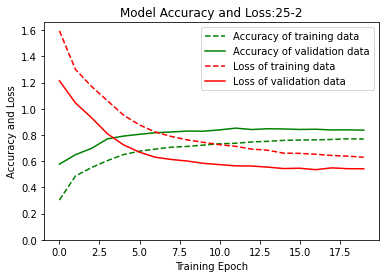


--- Check against test data ---

6584/6584 [==============================] - 0s 37us/step

Accuracy on test data: 0.77

Loss on test data: 0.60

--- Confusion matrix for test data ---



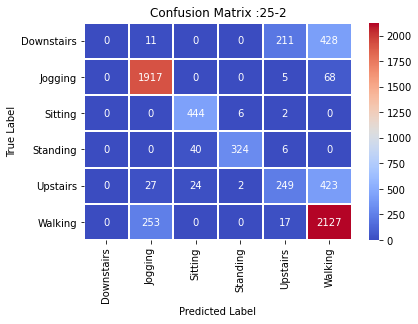


--- Classification report for test data 25:2---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.87      0.96      0.91      1990
           2       0.87      0.98      0.92       452
           3       0.98      0.88      0.92       370
           4       0.51      0.34      0.41       725
           5       0.70      0.89      0.78      2397

    accuracy                           0.77      6584
   macro avg       0.65      0.68      0.66      6584
weighted avg       0.69      0.77      0.72      6584

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 76, 25)            400       
______________________________________________________

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 52us/step - loss: 1.3418 - accuracy: 0.4424 - val_loss: 0.9514 - val_accuracy: 0.6646
Epoch 2/25
16694/16694 [==============================] - 1s 38us/step - loss: 0.9837 - accuracy: 0.6323 - val_loss: 0.6789 - val_accuracy: 0.7942
Epoch 3/25
16694/16694 [==============================] - 1s 39us/step - loss: 0.8333 - accuracy: 0.6864 - val_loss: 0.5818 - val_accuracy: 0.7973
Epoch 4/25
16694/16694 [==============================] - 1s 36us/step - loss: 0.7412 - accuracy: 0.7134 - val_loss: 0.5391 - val_accuracy: 0.8227
Epoch 5/25
16694/16694 [==============================] - 1s 46us/step - loss: 0.6752 - accuracy: 0.7339 - val_loss: 0.5080 - val_accuracy: 0.8395
Epoch 6/25
16694/16694 [==============================] - 1s 50us/step - loss: 0.6356 - accuracy: 0.7540 - val_loss: 0.4906 - val_accuracy: 0.8462
Epoch 7/25
16694/16694 [==============================] - 1s 53us/ste

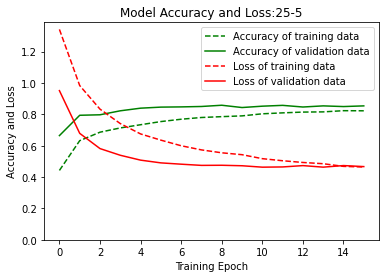


--- Check against test data ---

6584/6584 [==============================] - 0s 35us/step

Accuracy on test data: 0.82

Loss on test data: 0.46

--- Confusion matrix for test data ---



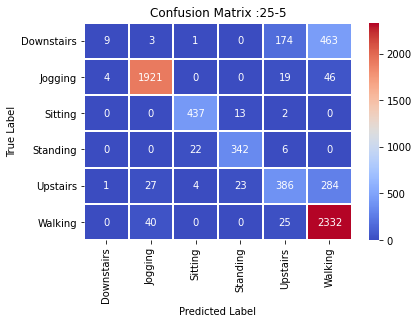


--- Classification report for test data 25:5---

              precision    recall  f1-score   support

           0       0.64      0.01      0.03       650
           1       0.96      0.97      0.97      1990
           2       0.94      0.97      0.95       452
           3       0.90      0.92      0.91       370
           4       0.63      0.53      0.58       725
           5       0.75      0.97      0.84      2397

    accuracy                           0.82      6584
   macro avg       0.81      0.73      0.71      6584
weighted avg       0.81      0.82      0.78      6584

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 73, 25)            625       
______________________________________________________

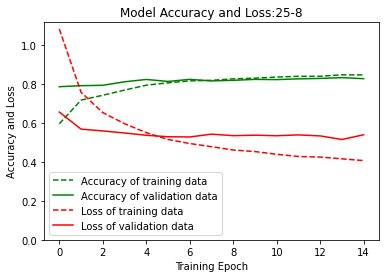


--- Check against test data ---

6584/6584 [==============================] - 0s 33us/step

Accuracy on test data: 0.85

Loss on test data: 0.43

--- Confusion matrix for test data ---



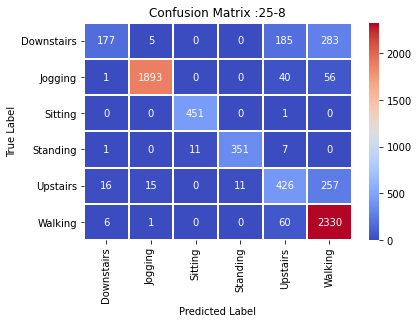


--- Classification report for test data 25:8---

              precision    recall  f1-score   support

           0       0.88      0.27      0.42       650
           1       0.99      0.95      0.97      1990
           2       0.98      1.00      0.99       452
           3       0.97      0.95      0.96       370
           4       0.59      0.59      0.59       725
           5       0.80      0.97      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.87      0.79      0.80      6584
weighted avg       0.86      0.85      0.84      6584

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_22 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 71, 25)            775       
______________________________________________________

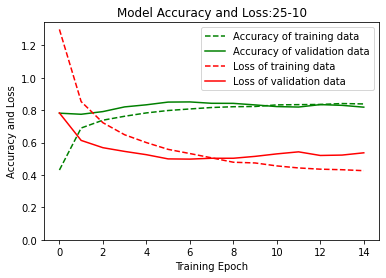


--- Check against test data ---

6584/6584 [==============================] - 0s 30us/step

Accuracy on test data: 0.83

Loss on test data: 0.48

--- Confusion matrix for test data ---



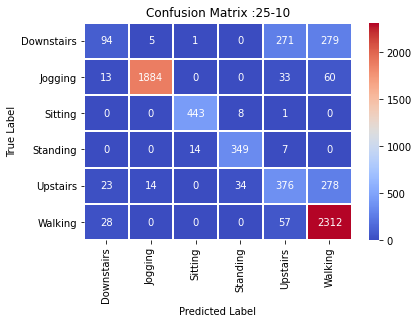


--- Classification report for test data 25:10---

              precision    recall  f1-score   support

           0       0.59      0.14      0.23       650
           1       0.99      0.95      0.97      1990
           2       0.97      0.98      0.97       452
           3       0.89      0.94      0.92       370
           4       0.50      0.52      0.51       725
           5       0.79      0.96      0.87      2397

    accuracy                           0.83      6584
   macro avg       0.79      0.75      0.75      6584
weighted avg       0.82      0.83      0.81      6584

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 69, 25)            925       
_____________________________________________________

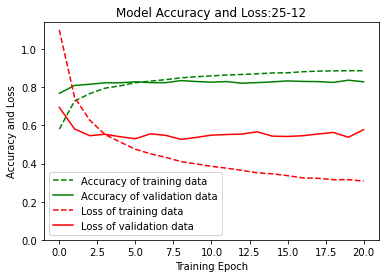


--- Check against test data ---

6584/6584 [==============================] - 0s 31us/step

Accuracy on test data: 0.88

Loss on test data: 0.42

--- Confusion matrix for test data ---



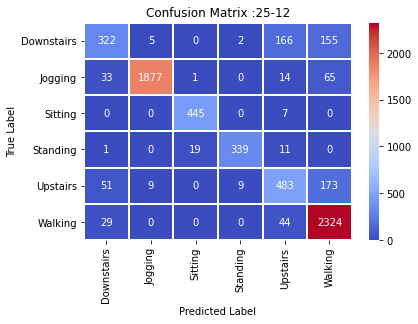


--- Classification report for test data 25:12---

              precision    recall  f1-score   support

           0       0.74      0.50      0.59       650
           1       0.99      0.94      0.97      1990
           2       0.96      0.98      0.97       452
           3       0.97      0.92      0.94       370
           4       0.67      0.67      0.67       725
           5       0.86      0.97      0.91      2397

    accuracy                           0.88      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.88      0.88      0.87      6584

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 66, 25)            1150      
_____________________________________________________

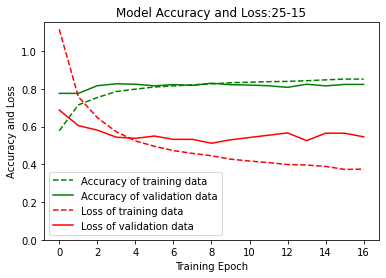


--- Check against test data ---

6584/6584 [==============================] - 0s 32us/step

Accuracy on test data: 0.85

Loss on test data: 0.45

--- Confusion matrix for test data ---



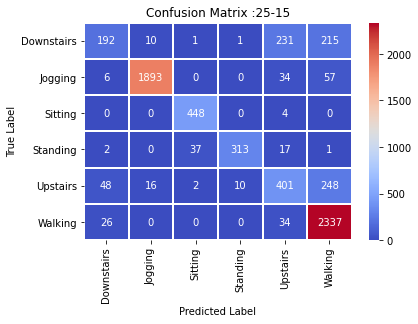


--- Classification report for test data 25:15---

              precision    recall  f1-score   support

           0       0.70      0.30      0.42       650
           1       0.99      0.95      0.97      1990
           2       0.92      0.99      0.95       452
           3       0.97      0.85      0.90       370
           4       0.56      0.55      0.55       725
           5       0.82      0.97      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.77      0.78      6584
weighted avg       0.84      0.85      0.83      6584

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 63, 25)            1375      
_____________________________________________________

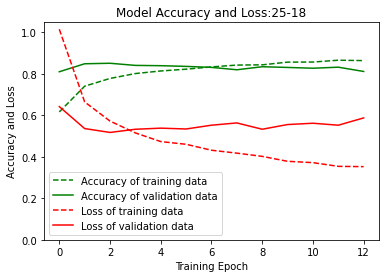


--- Check against test data ---

6584/6584 [==============================] - 0s 29us/step

Accuracy on test data: 0.86

Loss on test data: 0.47

--- Confusion matrix for test data ---



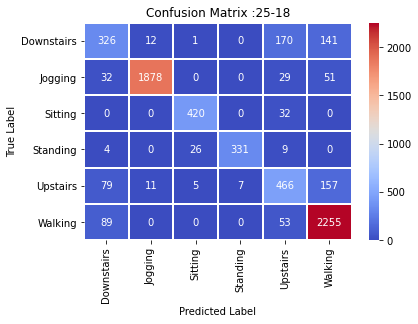


--- Classification report for test data 25:18---

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       650
           1       0.99      0.94      0.97      1990
           2       0.93      0.93      0.93       452
           3       0.98      0.89      0.94       370
           4       0.61      0.64      0.63       725
           5       0.87      0.94      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 61, 25)            1525      
_____________________________________________________

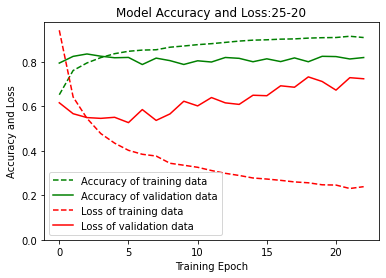


--- Check against test data ---

6584/6584 [==============================] - 0s 35us/step

Accuracy on test data: 0.87

Loss on test data: 0.59

--- Confusion matrix for test data ---



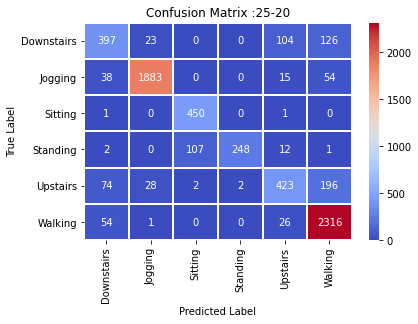


--- Classification report for test data 25:20---

              precision    recall  f1-score   support

           0       0.70      0.61      0.65       650
           1       0.97      0.95      0.96      1990
           2       0.81      1.00      0.89       452
           3       0.99      0.67      0.80       370
           4       0.73      0.58      0.65       725
           5       0.86      0.97      0.91      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.80      0.81      6584
weighted avg       0.87      0.87      0.86      6584

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 79, 35)            245       
_____________________________________________________

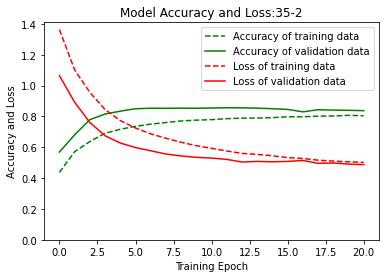


--- Check against test data ---

6584/6584 [==============================] - 0s 35us/step

Accuracy on test data: 0.78

Loss on test data: 0.52

--- Confusion matrix for test data ---



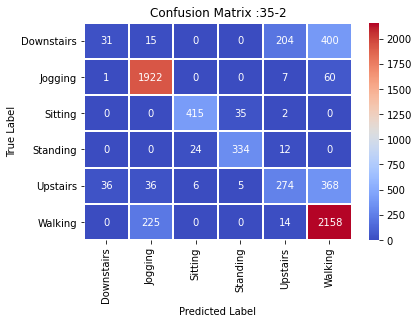


--- Classification report for test data 35:2---

              precision    recall  f1-score   support

           0       0.46      0.05      0.09       650
           1       0.87      0.97      0.92      1990
           2       0.93      0.92      0.93       452
           3       0.89      0.90      0.90       370
           4       0.53      0.38      0.44       725
           5       0.72      0.90      0.80      2397

    accuracy                           0.78      6584
   macro avg       0.74      0.69      0.68      6584
weighted avg       0.75      0.78      0.74      6584

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 76, 35)            560       
______________________________________________________

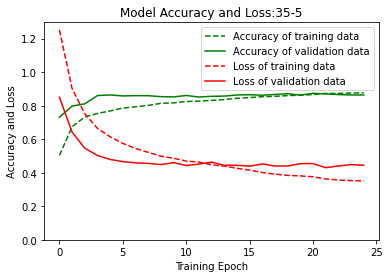


--- Check against test data ---

6584/6584 [==============================] - 0s 31us/step

Accuracy on test data: 0.86

Loss on test data: 0.40

--- Confusion matrix for test data ---



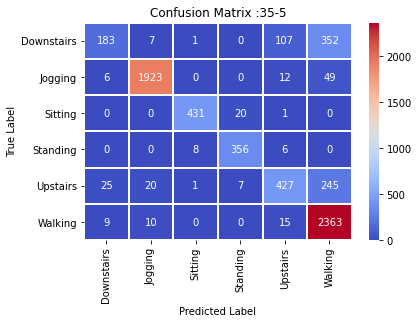


--- Classification report for test data 35:5---

              precision    recall  f1-score   support

           0       0.82      0.28      0.42       650
           1       0.98      0.97      0.97      1990
           2       0.98      0.95      0.97       452
           3       0.93      0.96      0.95       370
           4       0.75      0.59      0.66       725
           5       0.79      0.99      0.87      2397

    accuracy                           0.86      6584
   macro avg       0.87      0.79      0.81      6584
weighted avg       0.87      0.86      0.85      6584

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_29 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 73, 35)            875       
______________________________________________________

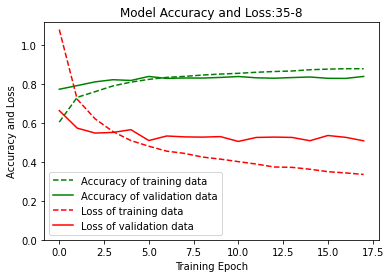


--- Check against test data ---

6584/6584 [==============================] - 0s 33us/step

Accuracy on test data: 0.87

Loss on test data: 0.40

--- Confusion matrix for test data ---



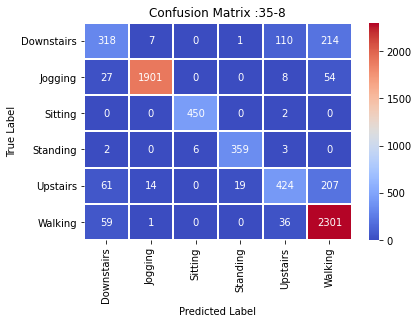


--- Classification report for test data 35:8---

              precision    recall  f1-score   support

           0       0.68      0.49      0.57       650
           1       0.99      0.96      0.97      1990
           2       0.99      1.00      0.99       452
           3       0.95      0.97      0.96       370
           4       0.73      0.58      0.65       725
           5       0.83      0.96      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.86      0.83      0.84      6584
weighted avg       0.87      0.87      0.87      6584

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 71, 35)            1085      
______________________________________________________

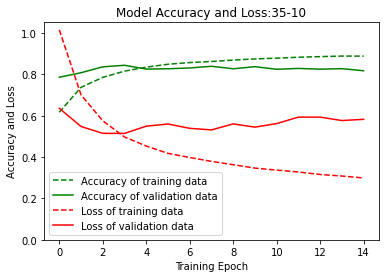


--- Check against test data ---

6584/6584 [==============================] - 0s 64us/step

Accuracy on test data: 0.89

Loss on test data: 0.36

--- Confusion matrix for test data ---



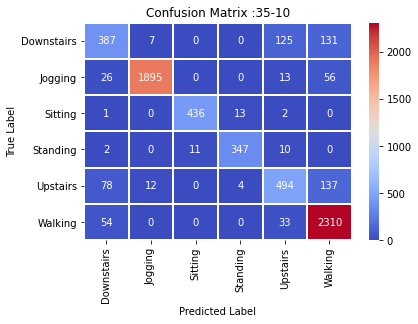


--- Classification report for test data 35:10---

              precision    recall  f1-score   support

           0       0.71      0.60      0.65       650
           1       0.99      0.95      0.97      1990
           2       0.98      0.96      0.97       452
           3       0.95      0.94      0.95       370
           4       0.73      0.68      0.70       725
           5       0.88      0.96      0.92      2397

    accuracy                           0.89      6584
   macro avg       0.87      0.85      0.86      6584
weighted avg       0.89      0.89      0.89      6584

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_31 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 69, 35)            1295      
_____________________________________________________

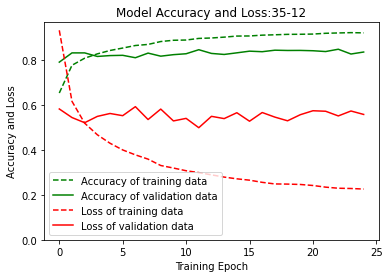


--- Check against test data ---

6584/6584 [==============================] - 0s 33us/step

Accuracy on test data: 0.90

Loss on test data: 0.37

--- Confusion matrix for test data ---



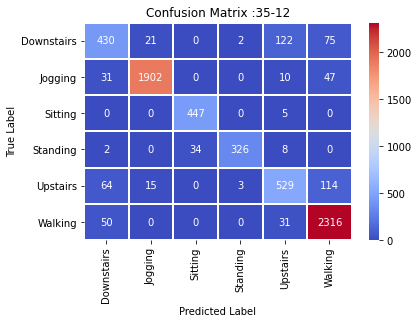


--- Classification report for test data 35:12---

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       650
           1       0.98      0.96      0.97      1990
           2       0.93      0.99      0.96       452
           3       0.98      0.88      0.93       370
           4       0.75      0.73      0.74       725
           5       0.91      0.97      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.86      0.87      6584
weighted avg       0.90      0.90      0.90      6584

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_32 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 66, 35)            1610      
_____________________________________________________

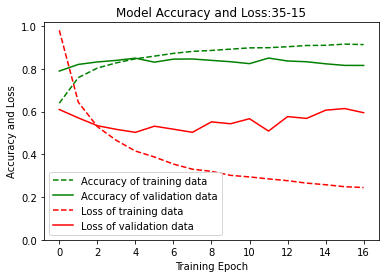


--- Check against test data ---

6584/6584 [==============================] - 0s 40us/step

Accuracy on test data: 0.87

Loss on test data: 0.40

--- Confusion matrix for test data ---



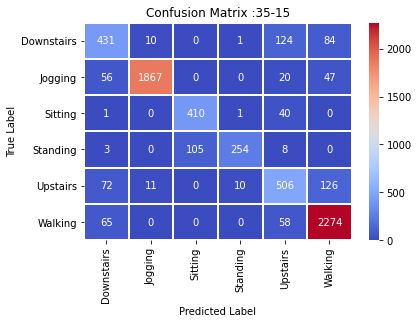


--- Classification report for test data 35:15---

              precision    recall  f1-score   support

           0       0.69      0.66      0.67       650
           1       0.99      0.94      0.96      1990
           2       0.80      0.91      0.85       452
           3       0.95      0.69      0.80       370
           4       0.67      0.70      0.68       725
           5       0.90      0.95      0.92      2397

    accuracy                           0.87      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.88      0.87      0.87      6584

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_33 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 63, 35)            1925      
_____________________________________________________

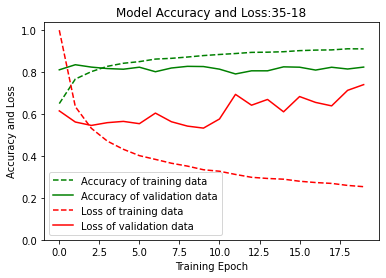


--- Check against test data ---

6584/6584 [==============================] - 0s 35us/step

Accuracy on test data: 0.86

Loss on test data: 0.54

--- Confusion matrix for test data ---



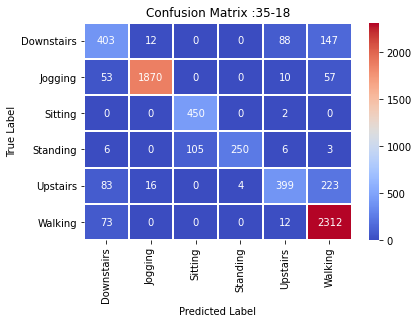


--- Classification report for test data 35:18---

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       650
           1       0.99      0.94      0.96      1990
           2       0.81      1.00      0.89       452
           3       0.98      0.68      0.80       370
           4       0.77      0.55      0.64       725
           5       0.84      0.96      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.79      0.81      6584
weighted avg       0.87      0.86      0.86      6584

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_34 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 61, 35)            2135      
_____________________________________________________

In [ ]:
val = {}
for k in [5,10,15,20,25,35,50,65,75,85,95,110,130,150,160,170,180,200]: #kernal
    tmp = []
    for f in [2,5,8,10,12,15,18,20]: #filter 
        if(k>f):
            try:
                tmp.append(call_model(k,f))
            except:
                print("----------Failed_______",f)
    val[k] = tmp
val
        

In [6]:
val

{5: [0.6336573362350464,
  0.6456561088562012,
  0.6526427865028381,
  0.6980558633804321,
  0.6868165135383606,
  0.7304070591926575,
  0.6816524863243103,
  0.7111178636550903],
 10: [0.6895503997802734,
  0.7998177409172058,
  0.7692891955375671,
  0.8081713318824768,
  0.8113608956336975,
  0.7978432774543762,
  0.7967800498008728,
  0.8280680179595947],
 15: [0.6980558633804321,
  0.8001214861869812,
  0.8156136274337769,
  0.8291312456130981,
  0.8339914679527283,
  0.8637606501579285,
  0.8421931862831116,
  0.8367254137992859],
 20: [0.7525820136070251,
  0.8254860043525696,
  0.8514580726623535,
  0.8140947818756104,
  0.8566220998764038,
  0.8699878454208374,
  0.8743924498558044,
  0.8150060772895813],
 25: [0.7550121545791626,
  0.8270048499107361,
  0.8687728047370911,
  0.8821384906768799,
  0.8809234499931335,
  0.8661907911300659,
  0.8724179863929749,
  0.8655832409858704],
 35: [0.7706561088562012,
  0.8517618179321289,
  0.8736330270767212,
  0.8728736042976379,
  0.

In [7]:
kernal_filter_mat = pd.DataFrame(val)
kernal_filter_mat["index"] = np.array([2,5,8,10,12,15,18,20])
kernal_filter_mat.set_index("index")

,5,10,15,20,25,35,50,65,75,85,95,110,130,150,160,170,180,200
index,,,,,,,,,,,,,,,,,,
2,0.633657,0.689550,0.698056,0.752582,0.755012,0.770656,0.783718,0.777947,0.785996,0.793135,0.788578,0.794957,0.805437,0.808627,0.797843,0.809083,0.818196,0.811361
5,0.645656,0.799818,0.800121,0.825486,0.827005,0.851762,0.866950,0.872722,0.878493,0.888821,0.889125,0.884113,0.895960,0.897479,0.883050,0.875000,0.898542,0.905529
8,0.652643,0.769289,0.815614,0.851458,0.868773,0.873633,0.901276,0.885936,0.878949,0.905680,0.879405,0.905377,0.918135,0.898086,0.919654,0.897175,0.915553,0.919046
10,0.698056,0.808171,0.829131,0.814095,0.882138,0.872874,0.900972,0.903706,0.904769,0.918742,0.910389,0.913882,0.911908,0.921324,0.905529,0.909326,0.907199,0.898694
12,0.686817,0.811361,0.833991,0.856622,0.880923,0.892163,0.886999,0.896567,0.900365,0.915553,0.897479,0.909174,0.899605,0.896871,0.895656,0.914338,0.900972,0.885480
15,0.730407,0.797843,0.863761,0.869988,0.866191,0.865128,0.880772,0.883657,0.887606,0.871507,0.878038,0.873633,0.868621,0.882746,0.877582,0.903554,0.878493,0.881379
18,0.681652,0.796780,0.842193,0.874392,0.872418,0.877734,0.870899,0.863305,0.870747,0.874089,0.856926,0.884265,0.874848,0.869836,0.889733,0.876974,0.863457,0.890492
20,0.711118,0.828068,0.836725,0.815006,0.865583,0.864824,0.860571,0.870444,0.879253,0.873329,0.876519,0.858141,0.881835,0.873633,0.876063,0.877886,0.873937,0.874392


In [8]:
import pickle
with open('kvsf_val.p','wb') as fp:
    pickle.dump(val,fp)
    
with open('kvsf.p','wb') as fp:
    pickle.dump(kernal_filter_mat,fp)

In [29]:
kernal_filter_mat["index"].values

array([ 2,  5,  8, 10, 12, 15, 18, 20])

In [31]:
final_val = []
for k,v in val.items():
    f_s = kernal_filter_mat["index"].values
    for i in range(len(f_s)):
        final_val.append([k,f_s[i],v[i]])
final_val

[[5, 2, 0.6336573362350464],
 [5, 5, 0.6456561088562012],
 [5, 8, 0.6526427865028381],
 [5, 10, 0.6980558633804321],
 [5, 12, 0.6868165135383606],
 [5, 15, 0.7304070591926575],
 [5, 18, 0.6816524863243103],
 [5, 20, 0.7111178636550903],
 [10, 2, 0.6895503997802734],
 [10, 5, 0.7998177409172058],
 [10, 8, 0.7692891955375671],
 [10, 10, 0.8081713318824768],
 [10, 12, 0.8113608956336975],
 [10, 15, 0.7978432774543762],
 [10, 18, 0.7967800498008728],
 [10, 20, 0.8280680179595947],
 [15, 2, 0.6980558633804321],
 [15, 5, 0.8001214861869812],
 [15, 8, 0.8156136274337769],
 [15, 10, 0.8291312456130981],
 [15, 12, 0.8339914679527283],
 [15, 15, 0.8637606501579285],
 [15, 18, 0.8421931862831116],
 [15, 20, 0.8367254137992859],
 [20, 2, 0.7525820136070251],
 [20, 5, 0.8254860043525696],
 [20, 8, 0.8514580726623535],
 [20, 10, 0.8140947818756104],
 [20, 12, 0.8566220998764038],
 [20, 15, 0.8699878454208374],
 [20, 18, 0.8743924498558044],
 [20, 20, 0.8150060772895813],
 [25, 2, 0.7550121545791626]

In [42]:
final_ker_filter = pd.DataFrame(final_val)
final_ker_filter.columns=['X',"Y","Z"]

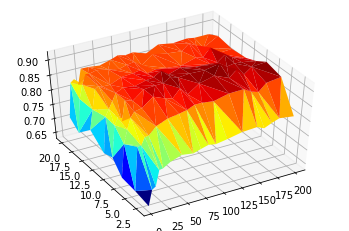

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(final_ker_filter["X"], final_ker_filter["Y"], final_ker_filter["Z"], cmap=plt.cm.jet, linewidth=0.2)
ax.view_init(45, 240)
plt.show()



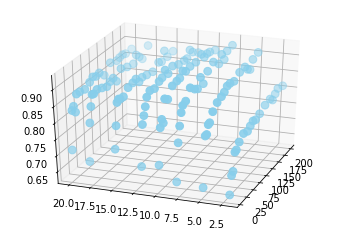

In [63]:
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_ker_filter["X"], final_ker_filter["Y"], final_ker_filter["Z"], c='skyblue', s=60)
ax.view_init(30, 200)#ax.view_init(30, 185)
plt.show()
